## MACHINE LEARNING MODULE 2021/2022

#### *Binary classification for cats and dogs*
https://unimibox.unimi.it/index.php/s/eNGYGSYmqynNMqF

The aim of this project is to build different models using the architecture of Convolutional Neural Network (CNN), that are able to recognize and classify images belonging to two different classes of pets: cats and dogs. 

## Loading libraries and modules

In [1]:
#!pip install -q -U keras-tuner
#!pip install visualkeras

In [1]:
import numpy as np
from numpy import expand_dims
import pandas as pd
import tensorflow as tf
import keras_tuner as kt

from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, zero_one_loss
import matplotlib.pyplot as plt
import random
import os
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.regularizers import l2
from keras.models import load_model

import visualkeras
import cv2
from tqdm import tqdm
import random
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import zero_one_loss

In [2]:
#set the random seed to 42 for reproducibility
tf.random.set_seed(42) 

In [3]:
#tensorflow version 
tf.__version__

'2.12.0'

In [4]:
IMG_PATH = r'C:\Users\giuli\Desktop\ProgettoML\dataset\CatsDogs'

#classes we have for binary classification
classes = os.listdir(IMG_PATH)
print(classes)

['Cats', 'Dogs']


#### Remove images

This function removes images (jpg files) that are not properly encoded, both for cats and dogs. To be correctly encoded, the encoding should start with the string "JFIF", which is verified by the function `is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)`

In [5]:
#Nota: rimossa l'opzione di cancellazione d'immagini se codificate in modo sbagliato
#check stringa JFIF: https://stackoverflow.com/questions/62220855/tensorflow-removing-jfif
num_skipped = 0
for folder_name in classes:
    folder_path = os.path.join(IMG_PATH, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath) #images are removed from the official folder
print("Deleted %d images" % num_skipped)

Deleted 1578 images


## Image Preprocessing

This function first reads the images and then creates different lists containing images with their corresponding labels, **0 for Cats** and **1 for Dogs**.
After some experiments I decide to not convert images into greyscale (1 channel) since I believe that color could be a significant factor for distinguishing between cats and dogs images.

In [5]:
def get_images(classes, IMG_PATH):
    images_cats = []
    labels_cats = []
    images_dogs = []
    labels_dogs = []
    
    labels = []
    images = []
    training_data = []

    for cl in classes:
        img_path = os.path.join(IMG_PATH, cl) #take the path of each folder (both cats and dogs)
        for img in tqdm(os.listdir(img_path)): #for each folder you are in take the images (first enter in cat folder and takes all the images of the cats and then does the same for the dogs)
            if os.path.exists(img_path): 
                try:
                    if cl == 'Dogs':
                        img_dog = cv2.imread(os.path.join(img_path, img)) #cv2.IMREAD_GRAYSCALE) #singular image of a dog
                        images_dogs.append(img_dog) #append all dogs images in an array
                        labels_dogs.append(1)
                    if cl == 'Cats':
                        img_cat = cv2.imread(os.path.join(img_path, img)) #cv2.IMREAD_GRAYSCALE) #singular image of a dog
                        images_cats.append(img_cat) #append all dogs images in an array 
                        labels_cats.append(0)
                except Exception as e:  
                    pass
                    
    images = [*images_cats, *images_dogs]
    labels = [*labels_cats, *labels_dogs]
              
    return images, images_cats, images_dogs, labels

In [6]:
images, images_cats, images_dogs, labels = get_images(classes, IMG_PATH)

100%|████████████████████████████████████████████████████████████████████████████| 11674/11674 [02:21<00:00, 82.30it/s]


In [7]:
#in total we have 23422 images 
print("number labeled of images", len(images))

number labeled of images 23422


The dataset is **balanced**, meaning that number of samples for each class is roughly equal. Having a balanced dataset is important in machine learning because it ensures that the learning algorithm is not biased towards any particular class. 

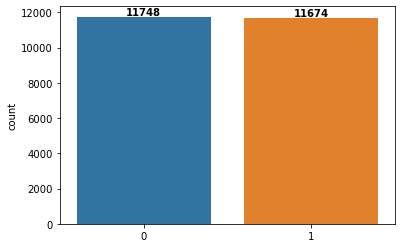

In [10]:
#sns.countplot(x=pd.Series(labels))
#plt.show()
sns.countplot(x=pd.Series(labels))
for i, v in enumerate(pd.Series(labels).value_counts()):
    plt.text(i, v, str(v), ha = 'center', va='bottom', fontweight='bold')
plt.show()

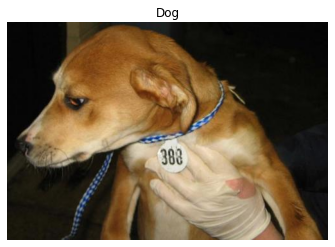

In [9]:
rgb_dog = cv2.cvtColor(images_dogs[10], cv2.COLOR_BGR2RGB) #open cv library reads the images in BGR so to show them I need to convert in RGB
plt.imshow(rgb_dog, cmap = plt.cm.Spectral)
plt.title('Dog')
plt.axis('off')
plt.show()

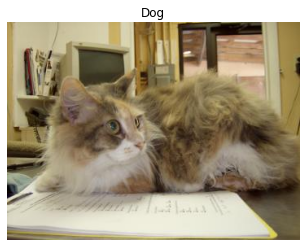

In [10]:
rgb_cat = cv2.cvtColor(images_cats[100], cv2.COLOR_BGR2RGB)
plt.imshow(rgb_cat, cmap = plt.cm.Spectral)
plt.title('Dog')
plt.axis('off')
plt.show()

## Resize
Since the images are all different (a bunch of shape of the images is shown in the cell below) I resize images to 80 x 80 pixels, doing a general reduce of quality in support of a faster converging of training process due to the limited resources capacities of my computer.

In [31]:
images_dogs[0].shape

(375, 500, 3)

In [32]:
images[50].shape

(274, 378, 3)

In [7]:
resized_images = []

for i in range(0, len(images)): 
    img = cv2.resize(images[i], dsize=(80, 80)) #influece the quality of the image
    resized_images.append(img)

In [8]:
resized_images[50].shape

(80, 80, 3)

Text(0.5, 0, 'shape (80, 80, 3)')

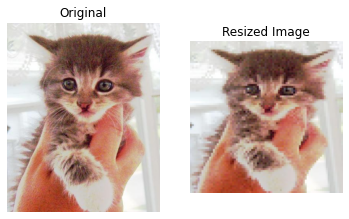

In [10]:
plt.subplot(1,2,1)
rgb_img = cv2.cvtColor(images[3], cv2.COLOR_BGR2RGB) #cv library convert img into BGR
plt.imshow(rgb_img, cmap = plt.cm.Spectral)
plt.title('Original')
plt.axis('off')
plt.xlabel('shape {}'.format(images[50].shape))
plt.subplot(1,2,2)

img_reshape = (80, 80) 

reshaped_img = cv2.resize(rgb_img , img_reshape)
plt.imshow(reshaped_img, cmap = plt.cm.Spectral) 
plt.title('Resized Image')
plt.axis('off')
plt.xlabel('shape {}'.format(reshaped_img.shape))


As we can see from the comparison of images above the quality of the new resized image is much lower.

## Training Data Construction

Building the training data with the resized image

In [9]:
training_data = []

for img, lab in zip(resized_images, labels):
    training_data.append([img, lab])

In [10]:
X = []
y = []

for features, labels in training_data:
    X.append(features)
    y.append(labels)

X = np.array(X).reshape(-1, 80, 80, 3)
y = np.array(y) # labels

# normalising the data
X = X / 255

In [11]:
X.shape

(23422, 80, 80, 3)

In [12]:
#shuffle of the training data
#random.shuffle(X)
#already done in splitting train and test and valid

**Train test split**
The stratify parameter ensures that the split produced maintains the same proportion of values as provided in the stratify parameter. For instance, consider a binary categorical variable y with values 0 and 1, where 25% of the data is labeled as 0 and 75% as 1. By specifying stratify=y, the random split will guarantee that the resulting subsets contain 25% of 0's and 75% of 1's.

In [12]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42, shuffle=True)

In [13]:
X_train.shape

(18737, 80, 80, 3)

Training data are divided into validation data.
Validation is carried out on a part of training data.

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, shuffle=True)  

In [15]:
print("training images")
print(len(X_train))
print("validation images, taken from a part of the training set:")
print(len(X_val))

training images
14989
validation images, taken from a part of the training set:
3748


#### Plot accuracy and loss

This function plots the loss and the accuracy of the models after the training step. 

In [17]:
def display_history(history):
    loss_training = history.history['loss']
    acc_training = history.history['accuracy']

    loss_val = history.history['val_loss']
    acc_val = history.history['val_accuracy']

    # Visualize the behavior of the loss
    plt.plot(loss_training)
    plt.plot(loss_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # and of the accuracy
    plt.plot(acc_training)
    plt.plot(acc_val)
    plt.grid()
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

# Baseline CNN - Model 1

Definition of a baseline Convolutional Neural Network (CNN) model.

In [81]:
## CNN Base
model1 = Sequential([
    # Step 1 - Convolution
    Conv2D(16, (3, 3), input_shape = (80, 80, 3), activation = 'relu'), 
    # Step 2 - Pooling
    MaxPooling2D(pool_size = (2, 2)),
    # Adding a second convolutional layer
    Conv2D(32, (3, 3), activation = 'relu'),
    MaxPooling2D(pool_size = (2, 2)),
    # Adding a third convolutional layer
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D((2, 2)),
    # Step 3 - Flattening
    Flatten(),
    # Step 4 - Full connection
    Dense(units = 64, activation = 'relu'), 
    Dense(units = 1, activation = 'sigmoid')
])

model1.compile(optimizer = Adam(learning_rate=0.0005), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [82]:
model1.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 78, 78, 16)        448       
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 39, 39, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 37, 37, 32)        4640      
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 18, 18, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 8, 8, 64)       

Model 1 has a total number of **trainable params** of  285,857, which is not an higher number compared to the other models implemented in this notebook. In general, I am aware that a lot of trainable parameters can lead to overfitting issues as the model is too complex with respect to the data available but, on the other hand, models with an higher number of trainable parameters are more flexible and able to capture patters in the data. As always, the data at hand are crucial. Moreover, all the models are trained locally, so due to my resource capacities it is difficult to train very complex and deep models. In addition, if a model has a lot of trainable parameters, it requires a significant amount of training data, if not enough data are provided the model isn't able to generalize well.

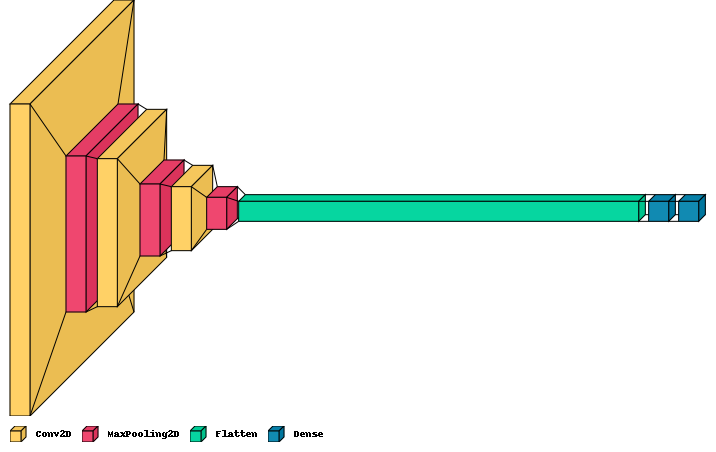

In [83]:
visualkeras.layered_view(model1, legend=True) 

In [30]:
#HYPERPARAMETERS OF MODEL 1
BATCH_SIZE = 32
EPOCHS = 10

In [85]:
#Training the model 
history1 = model1.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val))

Epoch 1/10
469/469 [==============================] - 41s 83ms/step - loss: 0.6156 - accuracy: 0.6509 - val_loss: 0.5477 - val_accuracy: 0.7236
Epoch 2/10
469/469 [==============================] - 33s 70ms/step - loss: 0.5152 - accuracy: 0.7449 - val_loss: 0.5005 - val_accuracy: 0.7620
Epoch 3/10
469/469 [==============================] - 34s 73ms/step - loss: 0.4656 - accuracy: 0.7796 - val_loss: 0.4863 - val_accuracy: 0.7628
Epoch 4/10
469/469 [==============================] - 35s 76ms/step - loss: 0.4259 - accuracy: 0.8051 - val_loss: 0.5139 - val_accuracy: 0.7455
Epoch 5/10
469/469 [==============================] - 36s 77ms/step - loss: 0.4032 - accuracy: 0.8149 - val_loss: 0.4487 - val_accuracy: 0.7876
Epoch 6/10
469/469 [==============================] - 34s 73ms/step - loss: 0.3657 - accuracy: 0.8369 - val_loss: 0.4108 - val_accuracy: 0.8127
Epoch 7/10
469/469 [==============================] - 34s 73ms/step - loss: 0.3403 - accuracy: 0.8460 - val_loss: 0.4273 - val_accuracy:

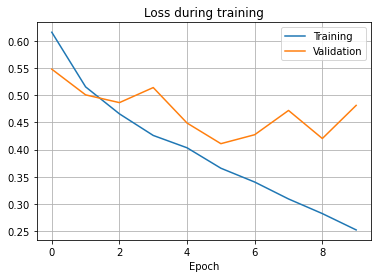

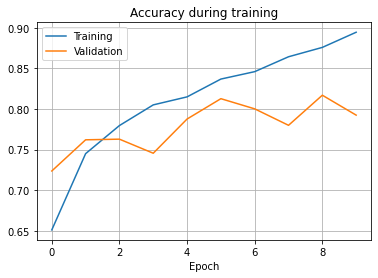

In [86]:
display_history(history1)

**Comments**: <br>
As we can see *model 1* shows some overfitting as it achieves a high training accuracy of 89.46% but much lower validation accuracy of 79.24%. As consequence the model is not able to generalize to new unseen data. Addressing overfitting is fundamental to improve model's performance on real-world data. 

# Model 2

From the results of the previous model, we try to face the overfitting issue and try to higher the accuracy, by:
* changing the hyperparameters of the convolutional layer in order to try diffierent convolutions
* add a dropout layers after the first max pooling and the second-to-last dense layer.
* added a different padding parameter, the default value is valid.

In [ ]:
#HYPERPARAMETERS model 2
#EPOCHS= 10
#BATCH_SIZE =32

In [16]:
model2 = Sequential([
    
    # Step 1 - Convolution
    Conv2D(32, (3, 3), input_shape = (80, 80, 3), activation = 'relu', padding="same"), #before 16 units
    # Step 2 - Pooling
    MaxPooling2D(pool_size = (2, 2)),
    #add Dropout rate to reduce overfitting
    Dropout(0.25),
    
    # Adding a 2nd convolutional layer
    Conv2D(32, (3, 3), activation = 'relu', padding="same"),
    MaxPooling2D(pool_size = (2, 2)),
    #Dropout(0.25),
    
    # Adding a 3rd convolutional layer
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2, 2)),
    #Dropout(0.10),
    
    # Step 3 - Flattening
    Flatten(),
    
    # Step 4 - Full connection
    Dense(units = 64, activation = 'relu'), 
    Dropout(0.50), 
    Dense(units = 1, activation = 'sigmoid')
])


model2.compile(optimizer = Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [18]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 40, 40, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 64)        1

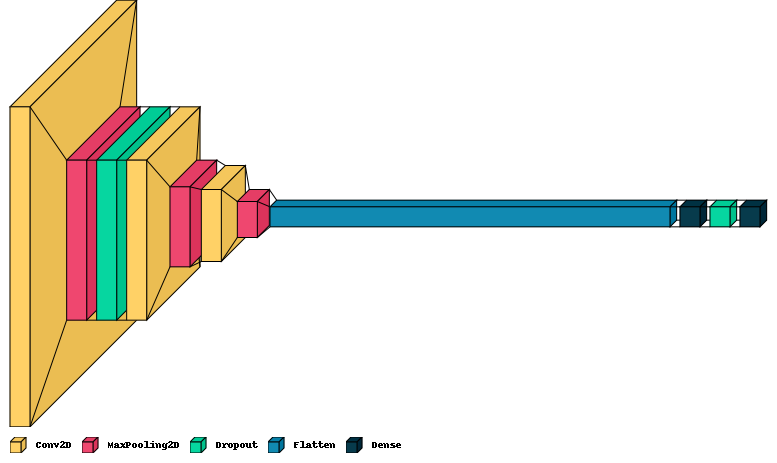

In [19]:
visualkeras.layered_view(model2, legend=True) 

In [20]:
history2 = model2.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val))

Epoch 1/10
469/469 [==============================] - 59s 118ms/step - loss: 0.6700 - accuracy: 0.5805 - val_loss: 0.6013 - val_accuracy: 0.7012
Epoch 2/10
469/469 [==============================] - 57s 121ms/step - loss: 0.5900 - accuracy: 0.6948 - val_loss: 0.5484 - val_accuracy: 0.7164
Epoch 3/10
469/469 [==============================] - 57s 121ms/step - loss: 0.5398 - accuracy: 0.7319 - val_loss: 0.5285 - val_accuracy: 0.7257
Epoch 4/10
469/469 [==============================] - 57s 122ms/step - loss: 0.5036 - accuracy: 0.7650 - val_loss: 0.5092 - val_accuracy: 0.7348
Epoch 5/10
469/469 [==============================] - 57s 122ms/step - loss: 0.4706 - accuracy: 0.7815 - val_loss: 0.4389 - val_accuracy: 0.7959
Epoch 6/10
469/469 [==============================] - 59s 127ms/step - loss: 0.4444 - accuracy: 0.8005 - val_loss: 0.4272 - val_accuracy: 0.8015
Epoch 7/10
469/469 [==============================] - 58s 123ms/step - loss: 0.4178 - accuracy: 0.8124 - val_loss: 0.4146 - val_ac

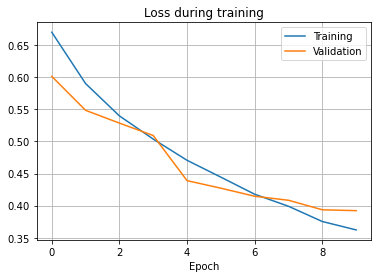

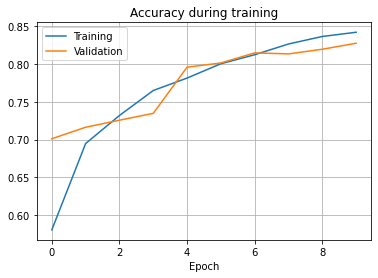

In [21]:
display_history(history2)

**Comments**: <br>
As we can see from the *model 2* the train and validation loss curves are much closer to each other, this is also true for accuracy curves. Accuracy curve for train reaches 84.22% while for valid set reaches 82.76% , this satisfactory result would probably improve if the epochs were increased or the batch size changed. 

## Model 3

Still a CNN with some further variations. I add the BatchNormalization layer after each activation layer and also two callbacks called when training the model. These callback are:
* Early Stopping: it monitors the loss of the validation set and it stops the training after a `patience` number of epochs when the monitored metric stops improving.
* Reduce On Plateau: reduce the learning rate by a factor of `2-10` (default) when the monitored metric (default is validation loss) stops improving.

In [30]:
#HYPERPARAMETERS model 3
#EPOCHS= 10
#BATCH_SIZE =32

In [20]:
model3 = Sequential([
    
    Conv2D(32, (3, 3), input_shape = (80, 80, 3), activation = 'relu', padding='same'), 
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation = 'relu', padding='same'), #before 32 units
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    #Dropout(0.2),
    
    Conv2D(128, (3,3), activation='relu',padding='same'), #before 64 units
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    #Dropout(0.20),
    
    Flatten(),

    Dense(units = 32, activation = 'relu'), #before 64
    BatchNormalization(),
    Dropout(0.50),
    Dense(units = 1, activation = 'sigmoid')
])

model3.compile(optimizer = Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [26]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 80, 80, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 40, 40, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 40, 40, 64)       2

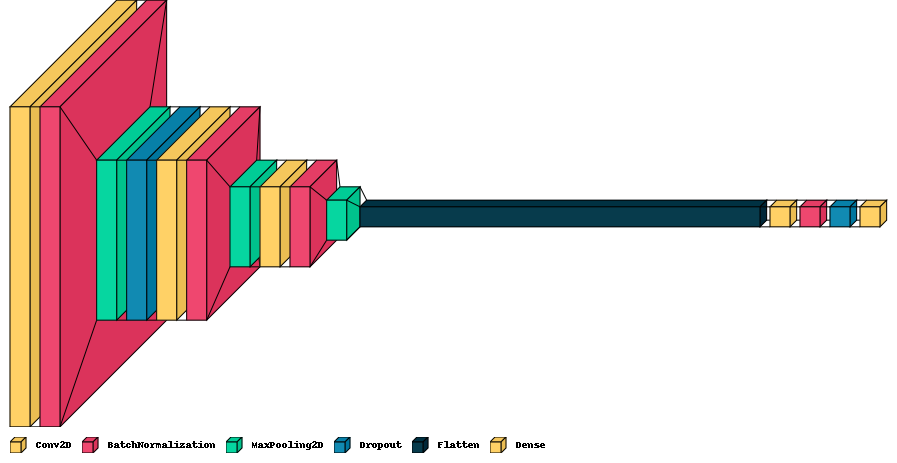

In [27]:
visualkeras.layered_view(model3, legend=True) 

In [15]:
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
# https://keras.io/api/callbacks/early_stopping/
# patience=Number of epochs with no improvement after which training will be stopped.

callbacks = [EarlyStopping(monitor='val_loss', patience=5), ReduceLROnPlateau(patience=2)]

In [31]:
history3 = model3.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/10
469/469 [==============================] - 214s 445ms/step - loss: 0.7161 - accuracy: 0.6525 - val_loss: 0.7103 - val_accuracy: 0.6278 - lr: 5.0000e-04
Epoch 2/10
469/469 [==============================] - 209s 445ms/step - loss: 0.5506 - accuracy: 0.7345 - val_loss: 0.4728 - val_accuracy: 0.7724 - lr: 5.0000e-04
Epoch 3/10
469/469 [==============================] - 206s 440ms/step - loss: 0.4757 - accuracy: 0.7705 - val_loss: 0.4333 - val_accuracy: 0.7972 - lr: 5.0000e-04
Epoch 4/10
469/469 [==============================] - 201s 428ms/step - loss: 0.4118 - accuracy: 0.8101 - val_loss: 0.6642 - val_accuracy: 0.7273 - lr: 5.0000e-04
Epoch 5/10
469/469 [==============================] - 201s 429ms/step - loss: 0.3677 - accuracy: 0.8387 - val_loss: 0.3980 - val_accuracy: 0.8164 - lr: 5.0000e-04
Epoch 6/10
469/469 [==============================] - 200s 427ms/step - loss: 0.3292 - accuracy: 0.8555 - val_loss: 0.4085 - val_accuracy: 0.8343 - lr: 5.0000e-04
Epoch 7/10
469/469 [==

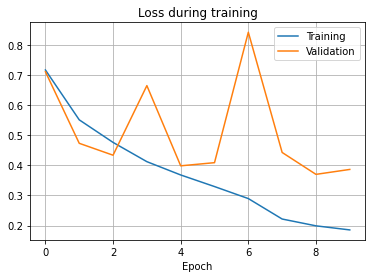

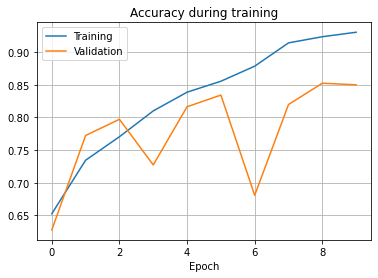

In [32]:
display_history(history3)

**Comments**: <br>
The *model 3* shows improvement in learning from the training data with a training accuracy of 93.05%. However, it experiences again overfitting as evidence by the significant fluctuations in validation accuracy and loss, indicating potential benefits from further fine-tuning or additional regularization techniques from more stable performance.


### MODEL 4
In this stage I try to use a common technique in machine learning called **data augmentation**. It's used to reduce overfitting when training a model, it consists in increasing the diversity of training set by applying random (but realistic) transformations on images. 
In addition, I use a regularization technique, int his case `facor L2`, that try to fix the lack of my model to generalize on unseen data by adding a penalty to the model's loss function.
- data augmentation 
- regularization factor L2

#### Data Augmentation

In [18]:
# create a sample of an image data sample generator created solely for the purpose of displaying augmented images
# Normalization Step It is not included here because if you normalise pixels between 0 and 1, visualisation is not possible.
train_generator = ImageDataGenerator(
    rotation_range=10,
    #brightness_range=[0.1,0.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2
) 

Visualization of a sample augmented image.

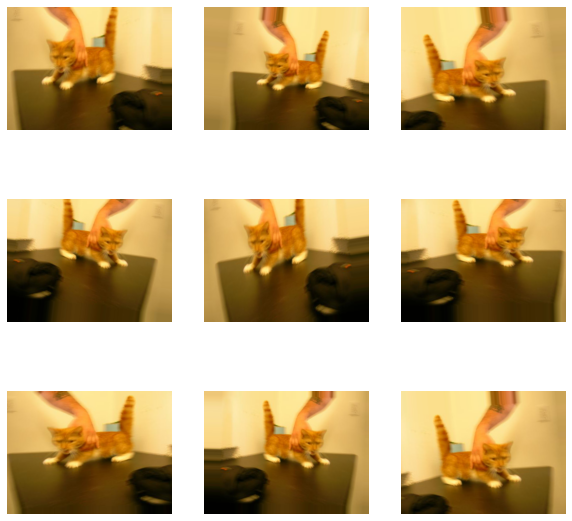

In [18]:
#data augmentation of a single image example plot
sample_img = tf.keras.utils.load_img(r'C:\Users\giuli\Desktop\ProgettoML\dataset\CatsDogs\Cats\0.jpg')
sample_img = tf.keras.utils.img_to_array(sample_img)

sample = expand_dims(sample_img, 0)

# prepare iterator
sample_augmented_img = train_generator.flow(sample, batch_size=1)

plt.figure(figsize=(10, 10))

# generate samples and plot
for i in range(0,9):
    # define subplot
    plt.subplot(3, 3, i+1)
    # generate batch of images
    batch = sample_augmented_img.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
    plt.axis('off')
    #plt.title('Augmented images')
# show the figure
plt.show()

### Model 4

In [19]:
#training data generator
train_augmented_data= train_generator.flow(X_train, y_train, batch_size=32)

In [11]:
#HYPERPARAMETERS model 4
EPOCHS= 15
#BATCH_SIZE =32

In [22]:
model4 = Sequential([
    
    Conv2D(32, (3, 3), input_shape = (80, 80, 3), activation = 'relu', padding='same', kernel_regularizer=l2(0.001)), 
    # Step 2 - Pooling
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(0.2),
    
    Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_regularizer=l2(0.001)),
    #BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2)),
        
    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    #BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    # Adding a 4th convolutional layer
    Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    #BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    # Step 3 - Flattening
    Flatten(),
    # Step 4 - Full connection
    Dense(units = 512, activation = 'relu', kernel_regularizer=l2(0.001)), 
    #BatchNormalization(),
    Dropout(0.30),
    Dense(units = 1, activation = 'sigmoid')
])

#AdamW -> Adam Weight decay
model4.compile(optimizer = AdamW(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=5), ReduceLROnPlateau(patience=2)]

**AdamW**, as alternative of Adam optimizer, is a stochastic optimization method that modifies the typical implementation of weight decay in Adam, by decoupling weight decay from the gradient update.

In [50]:
model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 80, 80, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 40, 40, 32)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 40, 40, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 20, 20, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 20, 20, 128)      

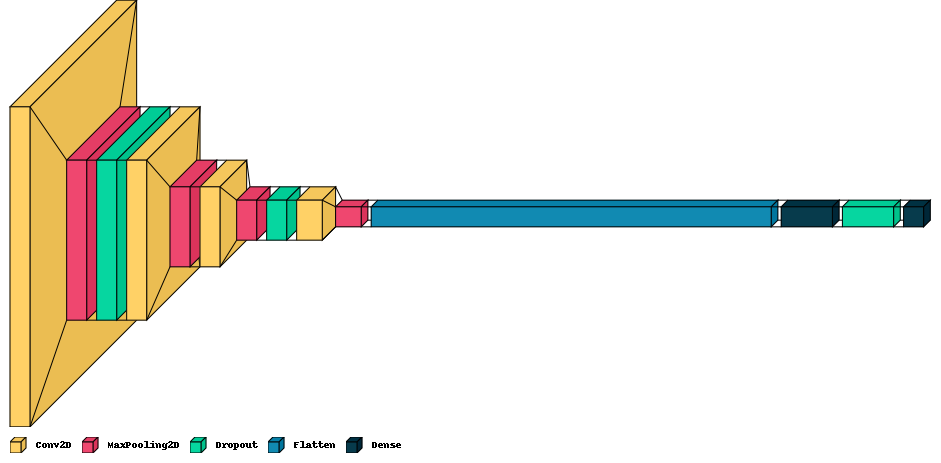

In [51]:
visualkeras.layered_view(model4, legend=True) 

In [54]:
history4 = model4.fit(train_augmented_data, epochs=EPOCHS, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/15
469/469 [==============================] - 106s 225ms/step - loss: 0.5492 - accuracy: 0.7782 - val_loss: 0.5307 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 2/15
469/469 [==============================] - 111s 237ms/step - loss: 0.5404 - accuracy: 0.7843 - val_loss: 0.5234 - val_accuracy: 0.7911 - lr: 1.0000e-04
Epoch 3/15
469/469 [==============================] - 112s 240ms/step - loss: 0.5371 - accuracy: 0.7822 - val_loss: 0.5193 - val_accuracy: 0.7954 - lr: 1.0000e-04
Epoch 4/15
469/469 [==============================] - 117s 248ms/step - loss: 0.5228 - accuracy: 0.7939 - val_loss: 0.4900 - val_accuracy: 0.8058 - lr: 1.0000e-04
Epoch 5/15
469/469 [==============================] - 114s 242ms/step - loss: 0.5170 - accuracy: 0.7963 - val_loss: 0.5058 - val_accuracy: 0.8052 - lr: 1.0000e-04
Epoch 6/15
469/469 [==============================] - 114s 243ms/step - loss: 0.5086 - accuracy: 0.7991 - val_loss: 0.5073 - val_accuracy: 0.8071 - lr: 1.0000e-04
Epoch 7/15
469/469 [==

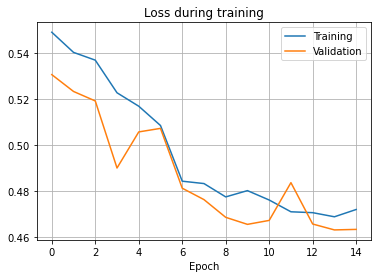

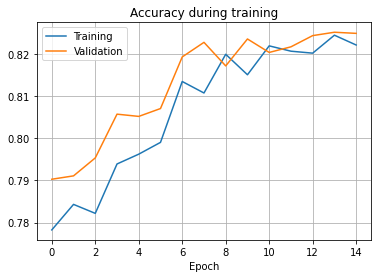

In [55]:
display_history(history4)

**Comments**: <br>
This last model consistently displayed an increasing validation accuracy throughout the epochs with small fluctuations. Its accuracy progressively improved over time without any evidence of overfitting. 
It reaches a peak validation accuracy of 82.50% at epoch 10, indicating that extended training led to better results.

### HYPERPARAMETER TUNING

In this section I use **Keras Tuner**, a brilliant tool that helps with hyperparameter tuning in a smart and convenient way. In fact, it uses a sampling algorithm for selecting the best hyperparameters combination from a list of all possible combinations.
The hyperparameters chosen are:
* number of units for 1st and 3rd convolutional layers
* dropout rate for one conv layer and for one dense layer
* number of units of the 1st dense layer
* learning rate for Adam optmizer

In [36]:
def model_cnn_ht(hp):
    
    model_ht = Sequential([
        
    Conv2D(hp.Int('filters1', min_value=16, max_value=32, step=16), (3, 3), input_shape = (80, 80, 3), padding='same', activation = 'relu'), 

    MaxPooling2D(pool_size = (2, 2)),
    Dropout(hp.Float("dropout1", 0, 0.5, step=0.1)),

    Conv2D(32, (3, 3), padding='same', activation = 'relu'),
    MaxPooling2D(pool_size = (2, 2)),
  
    Conv2D(hp.Int('filters2', min_value=32, max_value=128, step=32), (3,3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(units = hp.Int("units", min_value=64, max_value=256, step=32), activation = 'relu'), 
    Dropout(hp.Float("dropout2", 0, 0.5, step=0.1)),
    Dense(units = 1, activation = 'sigmoid')
    ])
    
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-4, 1e-3])
    

    model_ht.compile(optimizer = tf.keras.optimizers.experimental.Adam(learning_rate = hp_learning_rate), loss = tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics = ['accuracy'])
    
    
    return model_ht


In [37]:
tuner = kt.RandomSearch(
    model_cnn_ht, #choose a model
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory= r'C:\Users\giuli\Desktop\ProgettoML', 
    project_name='kt_tuning')

In [38]:
#once set up your tuner->tuner.search will start the hyperparamters search process, it's the method
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[callbacks])

Trial 10 Complete [00h 13m 59s]
val_accuracy: 0.7534685432910919

Best val_accuracy So Far: 0.8416488766670227
Total elapsed time: 02h 52m 03s
INFO:tensorflow:Oracle triggered exit


In [39]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(best_hps)

print(f"""The hyperparameter search is complete.\n
The optimal number of units for the first convolutional layer is {best_hps.get('filters1')}.\n
The optimal value for the first layer of droput is {best_hps.get('dropout1')}.\n
The optimal number of units for the third convolutional layer is {best_hps.get('filters2')}.\n
The optimal number of units in the first densely-connected layer is {best_hps.get('units')}.\n
The optimal value for the second layer of droput is {best_hps.get('dropout2')}.\n
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')} .""")

The hyperparameter search is complete.

The optimal number of units for the first convolutional layer is 16.

The optimal value for the first layer of droput is 0.1.

The optimal number of units for the third convolutional layer is 96.

The optimal number of units in the first densely-connected layer is 128.

The optimal value for the first layer of droput is 0.4.

The optimal learning rate for the optimizer is 0.001 .


*ther's a typo in "The optimal value for the first layer of droput is 0.4". Instead, it refers to the second dropout layer.

### Model 5

I construct the architecture of the last model with the values of hyperparameters that output the best performance in the section above.

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 10 epochs
model5 = tuner.hypermodel.build(best_hps)

In [28]:
model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 80, 80, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 40, 40, 16)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 40, 40, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 96)       

In [26]:
history5 = model5.fit(train_augmented_data, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
469/469 [==============================] - 48s 101ms/step - loss: 0.4516 - accuracy: 0.7932 - val_loss: 0.3515 - val_accuracy: 0.8503
Epoch 2/10
469/469 [==============================] - 55s 116ms/step - loss: 0.4053 - accuracy: 0.8165 - val_loss: 0.3801 - val_accuracy: 0.8332
Epoch 3/10
469/469 [==============================] - 54s 114ms/step - loss: 0.3893 - accuracy: 0.8255 - val_loss: 0.3305 - val_accuracy: 0.8498
Epoch 4/10
469/469 [==============================] - 61s 131ms/step - loss: 0.3771 - accuracy: 0.8331 - val_loss: 0.3701 - val_accuracy: 0.8396
Epoch 5/10
469/469 [==============================] - 60s 129ms/step - loss: 0.3685 - accuracy: 0.8369 - val_loss: 0.3358 - val_accuracy: 0.8543
Epoch 6/10
469/469 [==============================] - 58s 123ms/step - loss: 0.3582 - accuracy: 0.8371 - val_loss: 0.3291 - val_accuracy: 0.8599
Epoch 7/10
469/469 [==============================] - 53s 113ms/step - loss: 0.3461 - accuracy: 0.8490 - val_loss: 0.3547 - val_ac

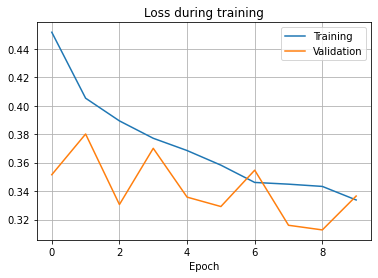

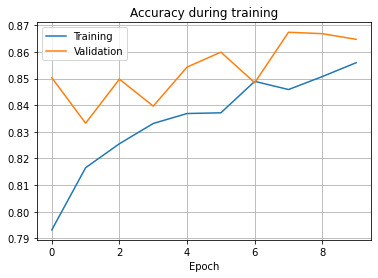

In [27]:
display_history(history5)

***Comments***: <br>
The *model 5* doesn't seem to be overfitting, but its overall performance is not good as I expected, due to the high number of fluctuations of validation curves. It achieves 84.85% of validation accuracy in epoch 7 but after that it tends to decrease. It’s also worth noting that validation accuracy is
sometimes higher than training accuracy because of data augmentation.

### Save and load the best Model

In [42]:
model2.save(r'C:\Users\giuli\Desktop\ProgettoML\models\model2.h5') #YOUR MODELS DIRECTORY

In [16]:
model2 = load_model(r'C:\Users\giuli\Desktop\ProgettoML\models\model2.h5')

## PREDICTION ON TEST SET 

I choose *model 2* both for its simplest architecture (due to limited resources capabilities of my computer) and for the excellent performance obtained during training and validation phases.

In [17]:
#BEST MODEL TO TEST
BEST_MODEL = model2

In [46]:
test_loss, test_acc = BEST_MODEL.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

147/147 [==============================] - 3s 22ms/step - loss: 0.4155 - accuracy: 0.8747
Test accuracy: 0.874706506729126


It turns out to output a test accuracy of
**87.47%** and a loss of **0.4155**.

In [47]:
y_pred = BEST_MODEL.predict(X_test, batch_size=32)

147/147 [==============================] - 3s 21ms/step


In [ ]:
y_pred

In [53]:
def predictions(y_pred): 
    y_pred_labels = np.round(y_pred).astype(int).reshape(-1)
    return (y_pred_labels > 0.5).astype("int32")

In [54]:
preds = predictions(y_pred)
print(preds)

[1 0 1 ... 1 1 0]


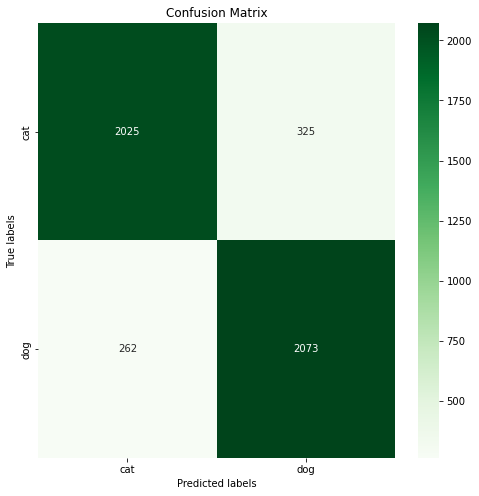

In [55]:
cm = confusion_matrix(y_test, preds)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', xticklabels=['cat', 'dog'], yticklabels=['cat', 'dog'])
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

The confusion matrix shows that the performance is a bit unbalanced:  the proportion of mistakes on cat images is higher than dog images for 63 images. Despite I'm satisfied of the overall performance, this suggests that there is potential for improvement and that with more time and computational resources, it may be possible to train a better model. 

## Test on new image

To test this model with new data, an image of a cat was taken from the internet and in this case
the model predicts the true.

In [56]:
sample_img_path = r'C:\Users\giuli\Desktop\ProgettoML\preds.jfif'

sample_pred = []

sample_img_pred = cv2.imread(sample_img_path) #cv2.IMREAD_GRAYSCALE)
sample_img_pred = cv2.resize(sample_img_pred, dsize=(80, 80))
sample_img_pred = cv2.cvtColor(sample_img_pred, cv2.COLOR_BGR2RGB) #open cv library reads the images in BGR so to show them I need to convert in RGB

sample_pred.append(sample_img_pred)

label = [0]

In [57]:
sample_data = []

for img, lab in zip(sample_pred, label):
    sample_data.append([img, lab])

In [58]:
X_sample = []
y_sample = []

for features, labels in sample_data:
    X_sample.append(features)
    y_sample.append(labels)

y_sample
X_sample = np.array(X_sample).reshape(-1, 80, 80, 3)
y_sample = np.array(y_sample) # labels

# normalising the data
X_sample = X_sample / 255

1/1 [==============================] - 0s 43ms/step
it's a cat


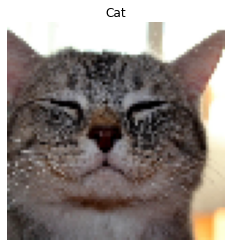

In [59]:
new_predic = BEST_MODEL.predict(X_sample)
sample_preds = predictions(new_predic)

if sample_preds < 0.5:
    print("it's a cat")
else:
    print("it's a dog")
    
plt.imshow(sample_img_pred, cmap = plt.cm.Spectral)
plt.title('Cat')
plt.axis('off')
plt.show()


## CROSS VALIDATION

Cross validation models helps to mitigate overfitting issue and have more accurate predictions.
The task requires to use 5-fold cross-validation to compute the risk estiments of my best model (*model 2*) and to use zero-one-loss function.\
The goal of this evaluation is to obtain an estimate of the generalization error (test error).

I run cross-validation over 5 epoches due to the limited resources of my computer, but of course to obtain more reliable results it would be better to run it over an higher number of epochs.

In [18]:
train_images = np.concatenate((X_train, X_val))
train_labels = np.concatenate((y_train, y_val))

In [19]:
train_images = train_images.astype('float32')

In [20]:
# Define the number of folds for cross-validation
num_folds = 5

# Initialize arrays for storing cross-validation scores
accuracy = []
zero_one_loss_arr = []
y_val_preds_cross = []

# Perform cross-validation
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42) 

cross_history = []
k_count = 1

print("perfroming cross validation...it may take a while")
for train_index, val_index in tqdm(kfold.split(train_images, train_labels)): 
    # Split the data into training and validation sets for each fold
    X_t, X_v = train_images[train_index], train_images[val_index] #X_t -> train images, X_v -> validation images
    y_t, y_v = train_labels[train_index], train_labels[val_index] #y_t -> train label, y_v -> validation label
    
    #Train the model on the training set for this fold
    #For each subset k train the model for X number of epochs
    history = BEST_MODEL.fit(X_t, y_t, epochs=5, batch_size=32, validation_data=(X_v, y_v),verbose=2)
    #Append the result in an array
    cross_history.append(history)

    # Evaluate the model on the validation set for this fold
    _ , acc = BEST_MODEL.evaluate(X_v, y_v)
    
    accuracy.append(acc) #accuracy can be seen as the zero one loss
    
    y_val_pred = BEST_MODEL.predict(X_v)
    y_val_pred = np.round(y_val_pred).flatten()
    
    #array of predictions
    y_val_preds_cross.append(y_val_pred)
    
    #zero one loss
    zeroOneLoss =zero_one_loss(y_v, y_val_pred)
    zero_one_loss_arr.append(zeroOneLoss)

    print(f"Fold {k_count} Zero One Loss: {zeroOneLoss:.3f}")
    k_count = k_count + 1
    
# Calculate and print the mean and standard deviation of the cross-validation scores
print(f"Mean Accuracy: {np.mean(accuracy):.4f}")
print(f"Mean Zero One Loss: {np.mean(zero_one_loss_arr):.4f}")

perfroming cross validation...it may take a while


0it [00:00, ?it/s]

Epoch 1/5
469/469 - 61s - loss: 0.6397 - accuracy: 0.6279 - val_loss: 0.5850 - val_accuracy: 0.6753 - 61s/epoch - 130ms/step
Epoch 2/5
469/469 - 58s - loss: 0.5605 - accuracy: 0.7199 - val_loss: 0.5036 - val_accuracy: 0.7489 - 58s/epoch - 123ms/step
Epoch 3/5
469/469 - 60s - loss: 0.5134 - accuracy: 0.7514 - val_loss: 0.4684 - val_accuracy: 0.7804 - 60s/epoch - 127ms/step
Epoch 4/5
469/469 - 58s - loss: 0.4608 - accuracy: 0.7838 - val_loss: 0.4369 - val_accuracy: 0.7922 - 58s/epoch - 124ms/step
Epoch 5/5
469/469 - 58s - loss: 0.4280 - accuracy: 0.8101 - val_loss: 0.4027 - val_accuracy: 0.8175 - 58s/epoch - 123ms/step
118/118 [==============================] - 5s 40ms/step


1it [05:05, 305.49s/it]

Fold 1 Zero One Loss: 0.182
Epoch 1/5
469/469 - 58s - loss: 0.4066 - accuracy: 0.8183 - val_loss: 0.3703 - val_accuracy: 0.8461 - 58s/epoch - 124ms/step
Epoch 2/5
469/469 - 56s - loss: 0.3745 - accuracy: 0.8358 - val_loss: 0.3651 - val_accuracy: 0.8402 - 56s/epoch - 119ms/step
Epoch 3/5
469/469 - 56s - loss: 0.3488 - accuracy: 0.8506 - val_loss: 0.3577 - val_accuracy: 0.8402 - 56s/epoch - 118ms/step
Epoch 4/5
469/469 - 57s - loss: 0.3105 - accuracy: 0.8690 - val_loss: 0.4370 - val_accuracy: 0.8114 - 57s/epoch - 121ms/step
Epoch 5/5
469/469 - 56s - loss: 0.2954 - accuracy: 0.8716 - val_loss: 0.3458 - val_accuracy: 0.8538 - 56s/epoch - 119ms/step
118/118 [==============================] - 3s 29ms/step


2it [09:56, 296.68s/it]

Fold 2 Zero One Loss: 0.146
Epoch 1/5
469/469 - 58s - loss: 0.3078 - accuracy: 0.8714 - val_loss: 0.2545 - val_accuracy: 0.8884 - 58s/epoch - 123ms/step
Epoch 2/5
469/469 - 55s - loss: 0.2823 - accuracy: 0.8829 - val_loss: 0.2465 - val_accuracy: 0.8959 - 55s/epoch - 117ms/step
Epoch 3/5
469/469 - 69s - loss: 0.2658 - accuracy: 0.8922 - val_loss: 0.2268 - val_accuracy: 0.9010 - 69s/epoch - 147ms/step
Epoch 4/5
469/469 - 59s - loss: 0.2383 - accuracy: 0.9013 - val_loss: 0.2331 - val_accuracy: 0.8935 - 59s/epoch - 126ms/step
Epoch 5/5
469/469 - 56s - loss: 0.2175 - accuracy: 0.9104 - val_loss: 0.2252 - val_accuracy: 0.9029 - 56s/epoch - 120ms/step
118/118 [==============================] - 3s 29ms/step


3it [15:00, 300.45s/it]

Fold 3 Zero One Loss: 0.097
Epoch 1/5
469/469 - 56s - loss: 0.2272 - accuracy: 0.9060 - val_loss: 0.1472 - val_accuracy: 0.9421 - 56s/epoch - 119ms/step
Epoch 2/5
469/469 - 55s - loss: 0.2086 - accuracy: 0.9161 - val_loss: 0.1606 - val_accuracy: 0.9314 - 55s/epoch - 117ms/step
Epoch 3/5
469/469 - 56s - loss: 0.1917 - accuracy: 0.9180 - val_loss: 0.1888 - val_accuracy: 0.9135 - 56s/epoch - 118ms/step
Epoch 4/5
469/469 - 56s - loss: 0.1770 - accuracy: 0.9292 - val_loss: 0.1863 - val_accuracy: 0.9237 - 56s/epoch - 119ms/step
Epoch 5/5
469/469 - 55s - loss: 0.1749 - accuracy: 0.9282 - val_loss: 0.1788 - val_accuracy: 0.9266 - 55s/epoch - 117ms/step
118/118 [==============================] - 3s 28ms/step
Fold 4 Zero One Loss: 0.073

4it [19:55, 298.16s/it]


Epoch 1/5
469/469 - 56s - loss: 0.1874 - accuracy: 0.9234 - val_loss: 0.0958 - val_accuracy: 0.9690 - 56s/epoch - 120ms/step
Epoch 2/5
469/469 - 55s - loss: 0.1696 - accuracy: 0.9298 - val_loss: 0.1164 - val_accuracy: 0.9541 - 55s/epoch - 118ms/step
Epoch 3/5
469/469 - 56s - loss: 0.1568 - accuracy: 0.9358 - val_loss: 0.0884 - val_accuracy: 0.9658 - 56s/epoch - 118ms/step
Epoch 4/5
469/469 - 56s - loss: 0.1469 - accuracy: 0.9400 - val_loss: 0.0899 - val_accuracy: 0.9621 - 56s/epoch - 119ms/step
Epoch 5/5
469/469 - 57s - loss: 0.1372 - accuracy: 0.9456 - val_loss: 0.0990 - val_accuracy: 0.9608 - 57s/epoch - 122ms/step
118/118 [==============================] - 3s 28ms/step


5it [24:43, 296.74s/it]

Fold 5 Zero One Loss: 0.039
Mean Accuracy: 0.8923
Mean Zero One Loss: 0.1077


* Mean Accuracy: 89.23%
* Mean Zero One Loss: 0.1077

In [23]:
def display_history_cross(history, num_folds):

    plt.title('Accuracy during training')
    
    for i in range(0, num_folds):
        plt.plot(history[i].history['accuracy'], label=f'Train Accuracy Fold: {i}')
        plt.plot(history[i].history['val_accuracy'],linestyle='--', label=f'Val Accuracy Fold: {i}')
        
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

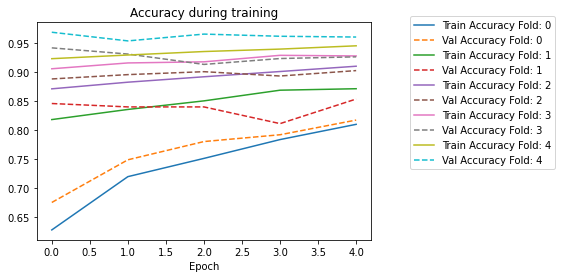

In [24]:
display_history_cross(cross_history, num_folds)

 I think it's a satisfactory result only for 5 epochs!

# Conclusion

The different models have their pros and cons. Having a large number of trainable parameters can
lead to increased overfitting and poorer generalization of the model, while having too few trainable parameters may result in the model not learning important features from the available images. Complex
networks also require higher computational resources. I start from a very baseline architecture and
gradually introducing improvement to its architecture. I have applied several regularization techniques
such as batch normalization, kernel regularizer, and dropout, and tried different callbacks during the
training process. However, the results vary (referring to the obtained graphs), and satisfactory accuracy is sometimes achieved in the validation set but future developments could involve experimenting with CNN with different resizing techniques (e.g., 200x200) and various types of data augmentation can be explored.